In [1]:
'''
After performing embedding extraction with RNA-FM, use this notebook
'''

import pickle
import torch
import random
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gc
import os
import math
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, 
    roc_auc_score, average_precision_score, balanced_accuracy_score, 
    precision_recall_curve, roc_curve
)

#hyperparameters
input_dimension = 1280
batch_size = 512 # no less than 2!

test_data_path = 'classification/single_interactions_RNA_FM/classification_mirna_mirna_test_RNAFM.p'
train_data_path = 'classification/single_interactions_RNA_FM/classification_mirna_mirna_train_RNAFM.p' # 
img_path = 'classification/images_FM_comp_mirna_mirna'
# create a dir in the imm_path dir, named test_data_path.split('/')[-1][:-2]
save_dir_img = os.path.join(img_path, test_data_path.split('/')[-1][:-2] + '_AVG_RNAFM')
os.makedirs(save_dir_img, exist_ok=True)

train_negative_reduction_factor = 1  # Reduce training set size by this factor for testing purposes
validation_split_ratio = 0.2  # Fraction of training set to use as validation
epochs = 50
learning_rate = 0.0005
num_layers = 4
dropout = 0.2
hidden_dimension = 1024
warmup_epochs = 4
patience = 10  # Early stopping patience
min_lr = 5e-5

# Dataset class with concatenated embeddings
class InteractionDataset(Dataset):
    def __init__(self, data_path, types=False):
        # Load the pickle file
        with open(data_path, 'rb') as f:
            self.data = pickle.load(f)
        self.types = []
        tmp = []
        if types:
            print('Creating a list for sample types - only for test set! -')
            for sample in self.data:
                if 'true' in sample:
                    tmp.append({'true': sample['true'][0]})
                    self.types.append((sample['true'][1], 1))
                else:
                    tmp.append({'negative': sample['negative'][0]})
                    self.types.append((sample['negative'][1], 0))
            self.data = tmp
        
        # Flatten the dataset
        self.flat_data = []
        with tqdm(total=len(self.data), desc="preparing dataset") as pbar:
            for item in self.data:
                pbar.update(1)
                if 'true' in item:
                    true = item['true']
                    # Keep only the last 1024 elements from the last dimension of each tensor.
                    el0_second_half = true[0][..., -640:]
                    el1_second_half = true[1][..., -640:]
                    
                    self.flat_data.extend([
                        (torch.cat((el0_second_half, el1_second_half), dim=-1).to('cpu'), 1)  # positive
                    ])
                elif 'negative' in item:
                    negative = item['negative']
                    # Keep only the last 1024 elements from the last dimension of each tensor.
                    el0_second_half = negative[0][..., -640:]
                    el1_second_half = negative[1][..., -640:]
                    
                    self.flat_data.extend([
                        (torch.cat((el0_second_half, el1_second_half), dim=-1).to('cpu'), 0)  # Negative
                    ])
        del self.data

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        embedding, label = self.flat_data[idx]
        return embedding, torch.tensor(label, dtype=torch.float32)




# Create datasets and dataloaders
full_train_data = InteractionDataset(train_data_path)
print('initial training data size: ', len(full_train_data))



# Reduce the training set size for negatives with train_negative_reduction_factor
negative_samples = [item for item in full_train_data.flat_data if item[1] == 0]
positive_samples = [item for item in full_train_data.flat_data if item[1] == 1]
print('negative_samples', len(negative_samples))
print('positive_samples', len(positive_samples))
# Shuffle negative samples
random.shuffle(negative_samples)


preparing dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 151262/151262 [00:01<00:00, 91529.19it/s]


initial training data size:  151262
negative_samples 143810
positive_samples 7452


In [2]:
def get_data_loaders_without_replacement(train_data,
                                         valid_data,
                                         batch_size,
                                         neg_batch_ratio=0.7):
    """
    Creates DataLoaders for training, validation, and test datasets with balanced batches.
    Negative samples are selected without replacement, and positive samples are resampled with replacement if necessary.

    Args:
        train_data (Subset): Training subset created using random_split.
        valid_data (Subset): Validation subset created using random_split.
        batch_size (int, optional): Number of samples per batch. Defaults to 1024.
        neg_batch_ratio (float, optional): Proportion of negative samples in each batch. Defaults to 0.5.

    Returns:
        Tuple[DataLoader, DataLoader]: DataLoaders for training, validation datasets.
    """
    # Helper function to extract data and labels from Subsets
    def extract_data_and_labels(subset):
        dataset = subset.dataset
        indices = subset.indices
        data = [dataset.flat_data[i] for i in indices]
        embeddings, labels = zip(*data)
        return torch.stack(embeddings), torch.tensor(labels)

    # Extract tensors for train and validation subsets
    train_inputs, train_labels = extract_data_and_labels(train_data)
    valid_inputs, valid_labels = extract_data_and_labels(valid_data)

    # Create TensorDatasets for DataLoader
    train_dataset = TensorDataset(train_inputs, train_labels)
    valid_dataset = TensorDataset(valid_inputs, valid_labels)

    # BalancedBatchSampler implementation
    class BalancedBatchSampler:
        def __init__(self, labels, batch_size, neg_batch_ratio):
            self.labels = labels.numpy() if torch.is_tensor(labels) else labels
            self.batch_size = batch_size
            self.neg_batch_ratio = neg_batch_ratio

            self.neg_indices = np.where(self.labels == 0)[0]
            self.pos_indices = np.where(self.labels == 1)[0]

            self.num_neg_per_batch = int(batch_size * neg_batch_ratio)
            self.num_pos_per_batch = batch_size - self.num_neg_per_batch

            self.num_neg_samples = len(self.neg_indices)

            # Calculate number of full batches
            self.num_batches = self.num_neg_samples // self.num_neg_per_batch

            # Check for leftover negatives
            self.leftover_negatives = self.num_neg_samples % self.num_neg_per_batch
            #if self.leftover_negatives > 0: # TODO fix, problema con ultima batch
            #    self.num_batches += 1  # Include the batch with leftover negatives

        def __iter__(self):
            neg_idx = np.random.permutation(self.neg_indices)
            pos_idx = self.pos_indices

            batch_start = 0
            for batch_num in range(self.num_batches):
                # Determine negatives in this batch
                if batch_num < self.num_batches - 1 or self.leftover_negatives == 0:
                    num_neg_in_batch = self.num_neg_per_batch
                else:
                    # Last batch with leftover negatives
                    num_neg_in_batch = self.leftover_negatives

                # Get negative indices for this batch
                neg_batch = neg_idx[batch_start:batch_start + num_neg_in_batch]
                batch_start += num_neg_in_batch

                # Number of positives to fill the batch
                num_pos_in_batch = self.batch_size - num_neg_in_batch

                # Sample positives with replacement
                pos_batch = np.random.choice(pos_idx, num_pos_in_batch, replace=True)

                # Combine and shuffle
                batch_indices = np.concatenate([neg_batch, pos_batch])
                np.random.shuffle(batch_indices)
                yield batch_indices.tolist()

        def __len__(self):
            return self.num_batches

    # Create DataLoader for training data with balanced batches
    train_sampler = BalancedBatchSampler(train_labels, batch_size, neg_batch_ratio)
    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=6)

    # Standard DataLoader for validation data
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

    return train_loader, valid_loader


# Reduce the negative samples based on the reduction factor
reduced_negative_size = int(len(negative_samples) // train_negative_reduction_factor)
print('reduced_negative_size', reduced_negative_size)

reduced_negative_samples = negative_samples[:reduced_negative_size]
print('reduced_negative_samples', len(reduced_negative_samples))

# Combine the reduced negatives with all positives
full_train_data.flat_data = positive_samples + reduced_negative_samples
print('reduced data size: ', len(full_train_data))

# Shuffle the dataset
random.shuffle(full_train_data.flat_data)

# Split the reduced training set into training and validation sets
train_size = int(len(full_train_data) * (1 - validation_split_ratio))
print('train_size', train_size)
val_size = len(full_train_data) - train_size
print('val_size', val_size)
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Create dataloaders
# OLD CODE
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
#val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
# NEW CODE
train_loader, val_loader = get_data_loaders_without_replacement(train_data, val_data, batch_size=batch_size)


# Clear the CUDA cache
torch.cuda.empty_cache()

# Optional: If you're running in a loop or after every epoch, you can manually free up GPU memory
gc.collect()  # This calls the garbage collector to release memory from Python objects


reduced_negative_size 143810
reduced_negative_samples 143810
reduced data size:  151262
train_size 121009
val_size 30253


0

In [3]:
class InteractionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=hidden_dimension, num_layers=num_layers, dropout=dropout):
        super(InteractionNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=self.dropout)]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())  # Ensure activation follows each linear layer
            layers.append(nn.Dropout(p=self.dropout))
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return self.sigmoid(x)


# Define model, optimizer, and loss function
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = InteractionNN(input_dim=input_dimension).to(device)  # Example input dim


# Define cosine annealing with warmup function
def cosine_annealing_with_warmup(epoch, warmup_epochs, max_epochs, min_lr=1e-5):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs  # Linear warmup
    else:
        cosine_decay = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (max_epochs - warmup_epochs)))
        return (cosine_decay * (1 - min_lr) + min_lr)

# Initialize optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: cosine_annealing_with_warmup(epoch, warmup_epochs, epochs, min_lr))
criterion = nn.BCELoss()



In [4]:
# Training loop
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_without_improvement = 0
model_name = 'best_model_mirna_mirna_aug_train_test_AVG-1022filter-RNAFM.pth'

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        embeddings, labels = batch
        embeddings = embeddings.squeeze(1).to(device)
        labels = labels.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = model(embeddings).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            embeddings, labels = batch
            embeddings = embeddings.to(device)
            labels = labels.to(device, dtype=torch.float32)
            outputs = model(embeddings).view(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)
    
    val_losses.append(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_name)  # Save best model
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best Validation Loss: {best_val_loss:.8f}")
        break
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.8f}, "
          f"Validation Loss: {val_losses[-1]:.8f}, LR: {current_lr:.8e}")


# Load the best model after training ends
model.load_state_dict(torch.load(model_name))
print("Best model loaded with lowest validation loss:", best_val_loss)


Epoch 1/50, Train Loss: 0.57822485, Validation Loss: 0.84979050, LR: 2.50000000e-04
Epoch 2/50, Train Loss: 0.52818932, Validation Loss: 0.87185914, LR: 3.75000000e-04
Epoch 3/50, Train Loss: 0.50277293, Validation Loss: 0.90401913, LR: 5.00000000e-04
Epoch 4/50, Train Loss: 0.50261778, Validation Loss: 0.61192042, LR: 5.00000000e-04
Epoch 5/50, Train Loss: 0.48839092, Validation Loss: 0.61265872, LR: 4.99417221e-04
Epoch 6/50, Train Loss: 0.46954387, Validation Loss: 0.48006259, LR: 4.97671603e-04
Epoch 7/50, Train Loss: 0.45776335, Validation Loss: 0.44724441, LR: 4.94771283e-04
Epoch 8/50, Train Loss: 0.44858126, Validation Loss: 0.41982444, LR: 4.90729785e-04
Epoch 9/50, Train Loss: 0.44339053, Validation Loss: 0.45941340, LR: 4.85565952e-04
Epoch 10/50, Train Loss: 0.44908145, Validation Loss: 0.43828297, LR: 4.79303860e-04
Epoch 11/50, Train Loss: 0.43415402, Validation Loss: 0.41334820, LR: 4.71972706e-04
Epoch 12/50, Train Loss: 0.42754323, Validation Loss: 0.36652344, LR: 4.63

In [5]:
color2 = '#9999CC'
color3 = '#00BBD8'
color_green = '#88B04B'
color_red = '#FF765B'
font_ticks = 16
font_labels = 18


heat0 = color_green
heat1 = '#648C28'
heat2 = '#204900'
heat3 = '#102A00'

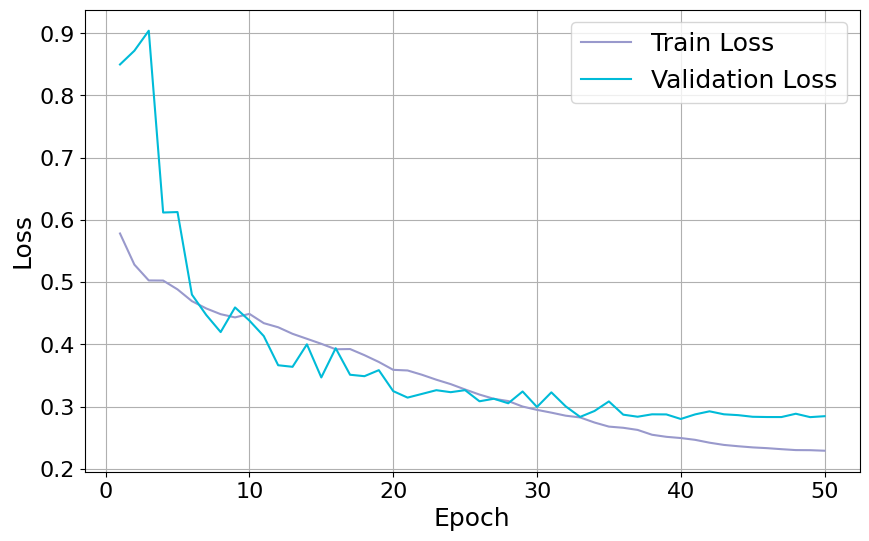

In [6]:
## batch fix 50% neg and pos
# Plotting the losses
epochs = len(train_losses)
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color=color2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color=color3)
plt.xlabel('Epoch', fontsize=font_labels)
plt.ylabel('Loss', fontsize=font_labels)
#plt.title('Training and Validation Loss')
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)

plt.legend(fontsize=font_labels)
plt.grid(True)
pdf_path = os.path.join(save_dir_img, "training_validation_loss.pdf")
plt.savefig(pdf_path, format='pdf')
plt.show()

In [7]:
print('Validation set evaluation')
# Load the best model after training ends
model.load_state_dict(torch.load(model_name))


import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_recall_fscore_support, roc_auc_score,
                             average_precision_score, confusion_matrix,
                             precision_recall_curve, roc_curve)

# --- Evaluation Loop ---
model.eval()
all_preds = []
all_labels = []
all_pred_prob = []

with torch.no_grad():
    for batch in val_loader:
        embeddings, labels = batch
        embeddings = embeddings.squeeze(1).to(device)  
        labels = labels.to(device, dtype=torch.float32)  
        
        # Compute model outputs; note that we do not threshold here.
        with torch.cuda.amp.autocast():
            outputs = model(embeddings).view(-1)  
            
        all_pred_prob.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_pred_prob = np.array(all_pred_prob)

# --- Automatic Threshold Selection ---
# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(all_labels, all_pred_prob)

# Compute the Euclidean distance from each point (FPR, TPR) to the perfect point (0, 1)
#distances = np.sqrt((1 - tpr)**2 + (fpr)**2)
#optimal_idx = np.argmin(distances)
#optimal_threshold = thresholds[optimal_idx]
#print(f"Optimal threshold (minimizing distance to (0,1)): {optimal_threshold:.4f}")


# Define a range of thresholds to evaluate
thresholds_to_eval = np.linspace(0, 1, 101)
#f1_scores = []
# Evaluate the F1 score for each threshold
#for thresh in thresholds_to_eval:
#    preds = (all_pred_prob > thresh).astype(np.float32)
#    f1 = f1_score(all_labels, preds)
#    f1_scores.append(f1)
# Select the threshold with the maximum F1 score
#optimal_threshold = thresholds_to_eval[np.argmax(f1_scores)]
#print(f"Optimal threshold (maximizing F1 score): {optimal_threshold:.4f}")

from sklearn.metrics import matthews_corrcoef

mcc_scores = []
for thresh in thresholds_to_eval:
    preds = (all_pred_prob > thresh).astype(np.float32)
    mcc = matthews_corrcoef(all_labels, preds)
    mcc_scores.append(mcc)

optimal_threshold = thresholds_to_eval[np.argmax(mcc_scores)]
print(f"Optimal threshold (maximizing MCC): {optimal_threshold:.4f}")


# Recompute predictions using the optimal threshold
optimal_preds = (all_pred_prob > optimal_threshold).astype(np.float32)

# --- Compute Metrics with the optimal threshold ---
accuracy = accuracy_score(all_labels, optimal_preds)
balanced_acc = balanced_accuracy_score(all_labels, optimal_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, optimal_preds, average='binary')
auroc = roc_auc_score(all_labels, all_pred_prob)
auprc = average_precision_score(all_labels, all_pred_prob)

# Print results
print(f"Accuracy: {accuracy:.6f}")
print(f"Balanced Accuracy: {balanced_acc:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"AUROC: {auroc:.6f}")
print(f"AUPRC: {auprc:.6f}")

metrics = {
    'Accuracy': accuracy, 'Balanced Accuracy': balanced_acc, 'Precision': precision, 
    'Recall': recall, 'F1': f1, 'AUROC': auroc, 'AUPRC': auprc
}



Validation set evaluation
Optimal threshold (maximizing MCC): 0.8300
Accuracy: 0.947642
Balanced Accuracy: 0.642800
Precision: 0.455000
Recall: 0.304552
F1 Score: 0.364876
AUROC: 0.823784
AUPRC: 0.318839


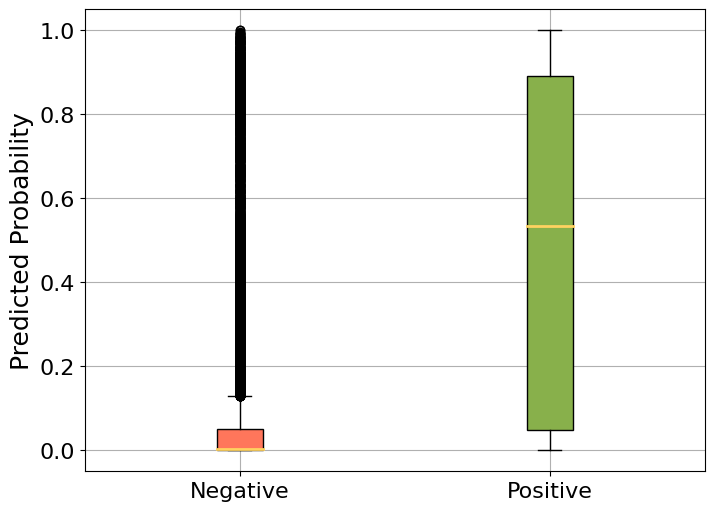

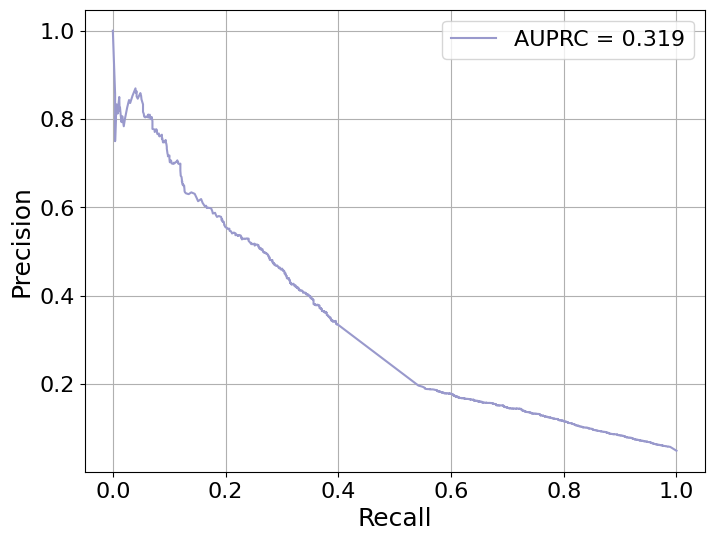

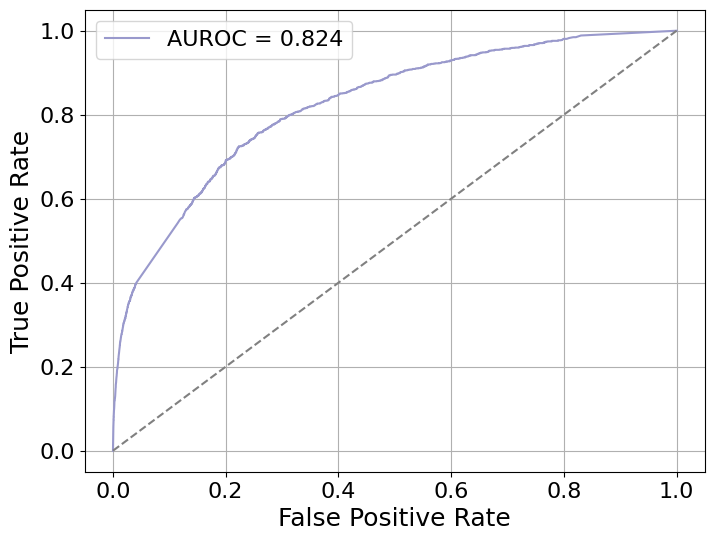

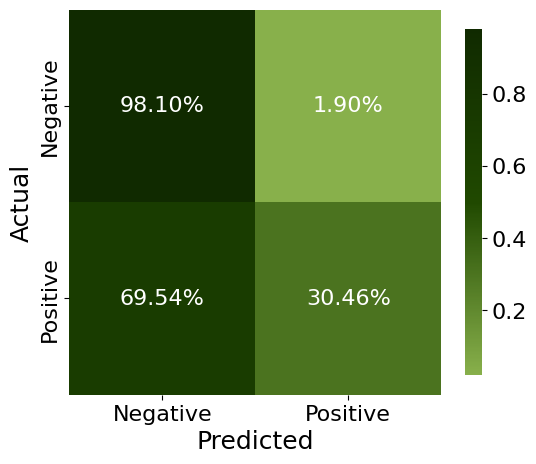

In [8]:
# --- Boxplots for Positive and Negative Prediction Probabilities ---
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(8, 6))
box = plt.boxplot([all_pred_prob[all_labels == 0], all_pred_prob[all_labels == 1]], 
                   labels=["Negative", "Positive"], patch_artist=True)

# Set colors: red for negatives, green for positives
box['boxes'][0].set(facecolor=color_red)   # Negative class (0)
box['boxes'][1].set(facecolor=color_green) # Positive class (1)

# Set median line color to color1
for median in box['medians']:
    median.set(color='#FFD260', linewidth=2)

plt.ylabel("Predicted Probability", fontsize=font_labels)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.grid()

# Save the image
plt.savefig(os.path.join(save_dir_img, "val_boxplot_probabilities.pdf"), bbox_inches="tight")
plt.show()
plt.close()


# --- Precision-Recall Curve ---
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"AUPRC = {auprc:.3f}", color=color2)
plt.xlabel("Recall", fontsize=font_labels)
plt.ylabel("Precision", fontsize=font_labels)
#plt.title("Precision-Recall Curve", fontsize=font_labels)
plt.legend(fontsize=font_ticks)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.grid()
# Save the image
plt.savefig(os.path.join(save_dir_img, "val_precision_recall_curve.pdf"), bbox_inches="tight")
plt.show()
plt.close()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}", color=color2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate", fontsize=font_labels)
plt.ylabel("True Positive Rate", fontsize=font_labels)
#plt.title("ROC Curve", fontsize=font_labels)
plt.legend(fontsize=font_ticks)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.grid()
# Save the image
plt.savefig(os.path.join(save_dir_img, "val_roc_curve.pdf"), bbox_inches="tight")
plt.show()
plt.close()

# Create a softer version of "Oranges" with transparency-like effect
colors = [heat0, heat2, heat3]  # Light orange → Medium → Darker
custom_cmap = LinearSegmentedColormap.from_list("soft_oranges", colors)

# --- Confusion Matrix (Normalized by row percentages) ---
cm = confusion_matrix(all_labels, optimal_preds, normalize='true')  # Normalize by row

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='.2%', cmap=custom_cmap, 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], 
                annot_kws={"size": font_ticks},  # Bigger font for percentages
                cbar_kws={"shrink": 0.9})  # Bigger legend

plt.xlabel('Predicted', fontsize=font_labels)
plt.ylabel('Actual', fontsize=font_labels)
# plt.title('Confusion Matrix (Normalized)', fontsize=font_labels)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)

cbar = ax.collections[0].colorbar  
cbar.ax.yaxis.set_tick_params(labelsize=font_ticks)  # Bigger font for legend tick values


# Save the image
plt.savefig(os.path.join(save_dir_img, "val_confusion_matrix_normalized.pdf"), bbox_inches="tight")
plt.show()
plt.close()


In [9]:
# Create datasets and dataloaders
test_data = InteractionDataset(test_data_path, types=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6)



preparing dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 17159/17159 [00:00<00:00, 104009.89it/s]


In [10]:
from sklearn.metrics import roc_curve
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_recall_fscore_support, roc_auc_score,
                             average_precision_score, confusion_matrix,
                             precision_recall_curve, roc_curve)

# --- Evaluation Loop ---
model.eval()
all_preds = []
all_labels = []
all_pred_prob = []

with torch.no_grad():
    for batch in test_loader:
        embeddings, labels = batch
        embeddings = embeddings.squeeze(1).to(device)  
        labels = labels.to(device, dtype=torch.float32)  
        
        # Compute model outputs; note that we do not threshold here.
        with torch.cuda.amp.autocast():
            outputs = model(embeddings).view(-1)  
            
        all_pred_prob.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_pred_prob = np.array(all_pred_prob)


print(f"Optimal threshold found in val dataset (maximizinf validation f1): {optimal_threshold:.4f}")

# Recompute predictions using the optimal threshold
optimal_preds = (all_pred_prob > optimal_threshold).astype(np.float32)

# --- Compute Metrics with the optimal threshold ---
accuracy = accuracy_score(all_labels, optimal_preds)
balanced_acc = balanced_accuracy_score(all_labels, optimal_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, optimal_preds, average='binary')
auroc = roc_auc_score(all_labels, all_pred_prob)
auprc = average_precision_score(all_labels, all_pred_prob)

# Print results
print(f"Accuracy: {accuracy:.6f}")
print(f"Balanced Accuracy: {balanced_acc:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"AUROC: {auroc:.6f}")
print(f"AUPRC: {auprc:.6f}")

metrics = {
    'Accuracy': accuracy, 'Balanced Accuracy': balanced_acc, 'Precision': precision, 
    'Recall': recall, 'F1': f1, 'AUROC': auroc, 'AUPRC': auprc
}




Optimal threshold found in val dataset (maximizinf validation f1): 0.8300
Accuracy: 0.924529
Balanced Accuracy: 0.650078
Precision: 0.277190
Recall: 0.346154
F1 Score: 0.307857
AUROC: 0.809426
AUPRC: 0.226910


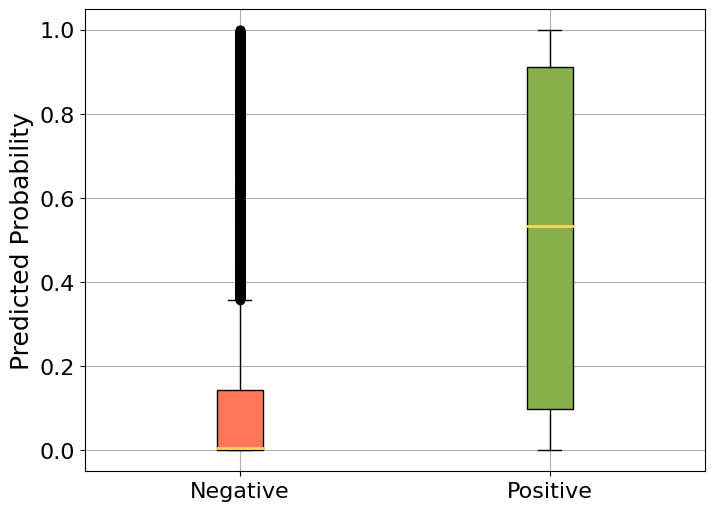

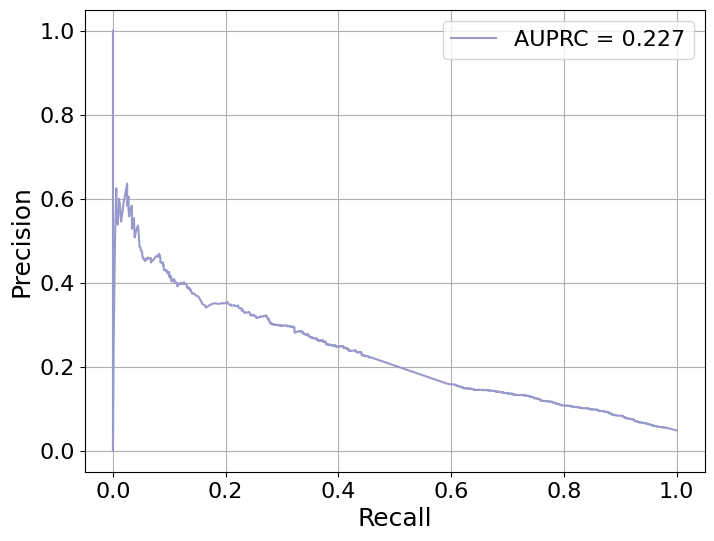

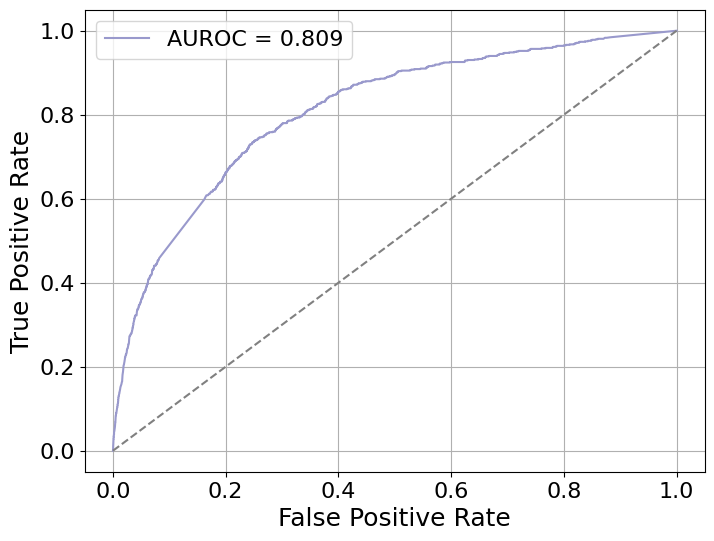

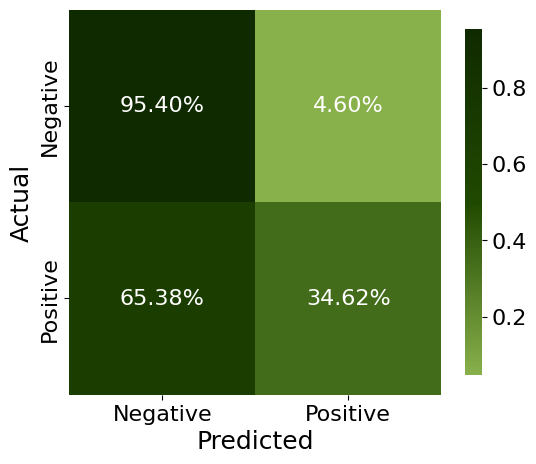

In [11]:
# --- Boxplots for Positive and Negative Prediction Probabilities ---
plt.figure(figsize=(8, 6))
box = plt.boxplot([all_pred_prob[all_labels == 0], all_pred_prob[all_labels == 1]], 
                   labels=["Negative", "Positive"], patch_artist=True)

# Set colors: red for negatives, green for positives
box['boxes'][0].set(facecolor=color_red)   # Negative class (0)
box['boxes'][1].set(facecolor=color_green) # Positive class (1)

# Set median line color to color1
for median in box['medians']:
    median.set(color='#FFD260', linewidth=2)

plt.ylabel("Predicted Probability", fontsize=font_labels)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.grid()

# Save the image
plt.savefig(os.path.join(save_dir_img, "test_boxplot_probabilities.pdf"), bbox_inches="tight")
plt.show()
plt.close()


# --- Precision-Recall Curve ---
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"AUPRC = {auprc:.3f}", color=color2)
plt.xlabel("Recall", fontsize=font_labels)
plt.ylabel("Precision", fontsize=font_labels)
#plt.title("Precision-Recall Curve", fontsize=font_labels)
plt.legend(fontsize=font_ticks)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.grid()
# Save the image
plt.savefig(os.path.join(save_dir_img, "test_precision_recall_curve.pdf"), bbox_inches="tight")
plt.show()
plt.close()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}", color=color2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate", fontsize=font_labels)
plt.ylabel("True Positive Rate", fontsize=font_labels)
#plt.title("ROC Curve", fontsize=font_labels)
plt.legend(fontsize=font_ticks)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.grid()
# Save the image
plt.savefig(os.path.join(save_dir_img, "test_roc_curve.pdf"), bbox_inches="tight")
plt.show()
plt.close()

# --- Confusion Matrix (Normalized by row percentages) ---
cm = confusion_matrix(all_labels, optimal_preds, normalize='true')  # Normalize by row

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='.2%', cmap=custom_cmap, 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], 
                annot_kws={"size": font_ticks},  # Bigger font for percentages
                cbar_kws={"shrink": 0.9})  # Bigger legend

plt.xlabel('Predicted', fontsize=font_labels)
plt.ylabel('Actual', fontsize=font_labels)
# plt.title('Confusion Matrix (Normalized)', fontsize=font_labels)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)

cbar = ax.collections[0].colorbar  
cbar.ax.yaxis.set_tick_params(labelsize=font_ticks)  # Bigger font for legend tick values


# Save the image
plt.savefig(os.path.join(save_dir_img, "test_confusion_matrix_normalized.pdf"), bbox_inches="tight")
plt.show()
plt.close()